# Notebook for Feature Engineering and dataset building

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import re

import emoji
import datetime

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from transformers import pipeline

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from textblob import TextBlob
from scipy.stats import skew,kurtosis,norm,skewtest,kurtosistest
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

import pylab
import scipy.stats as stats

import statsmodels.api as sm
import pylab as py

import arch.bootstrap as bootstrap
from numpy.random import RandomState

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tuomasp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tuomasp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tuomasp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tuomasp/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2023-06-04 17:09:35.026329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 17:09:35.429804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.

In [2]:
# Data frame :
# https://data.world/barbaramaseda/elon-musk-tweets/workspace/file?filename=user-tweets.jsonl
#Didn't use API because not for free


#Reading the json file
tweets = pd.read_json('user-tweets.jsonl', lines=True)


#Getting rid of irrelevant columns in our dataframe
tweets = tweets.drop(['UserName','LinkToTweet', 'TweetEmbedCode'], axis = 1)

#Converting the date column to datetime format
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'])

#Rename the column to date 
tweets = tweets.rename(columns={'CreatedAt': 'Date'})

#Setting the date column as index for the dataframe 
tweets.set_index('Date', inplace=True)


#Dropping 2017 till 2019
tweets = tweets.drop(tweets[tweets.index < '2020-01-01'].index)


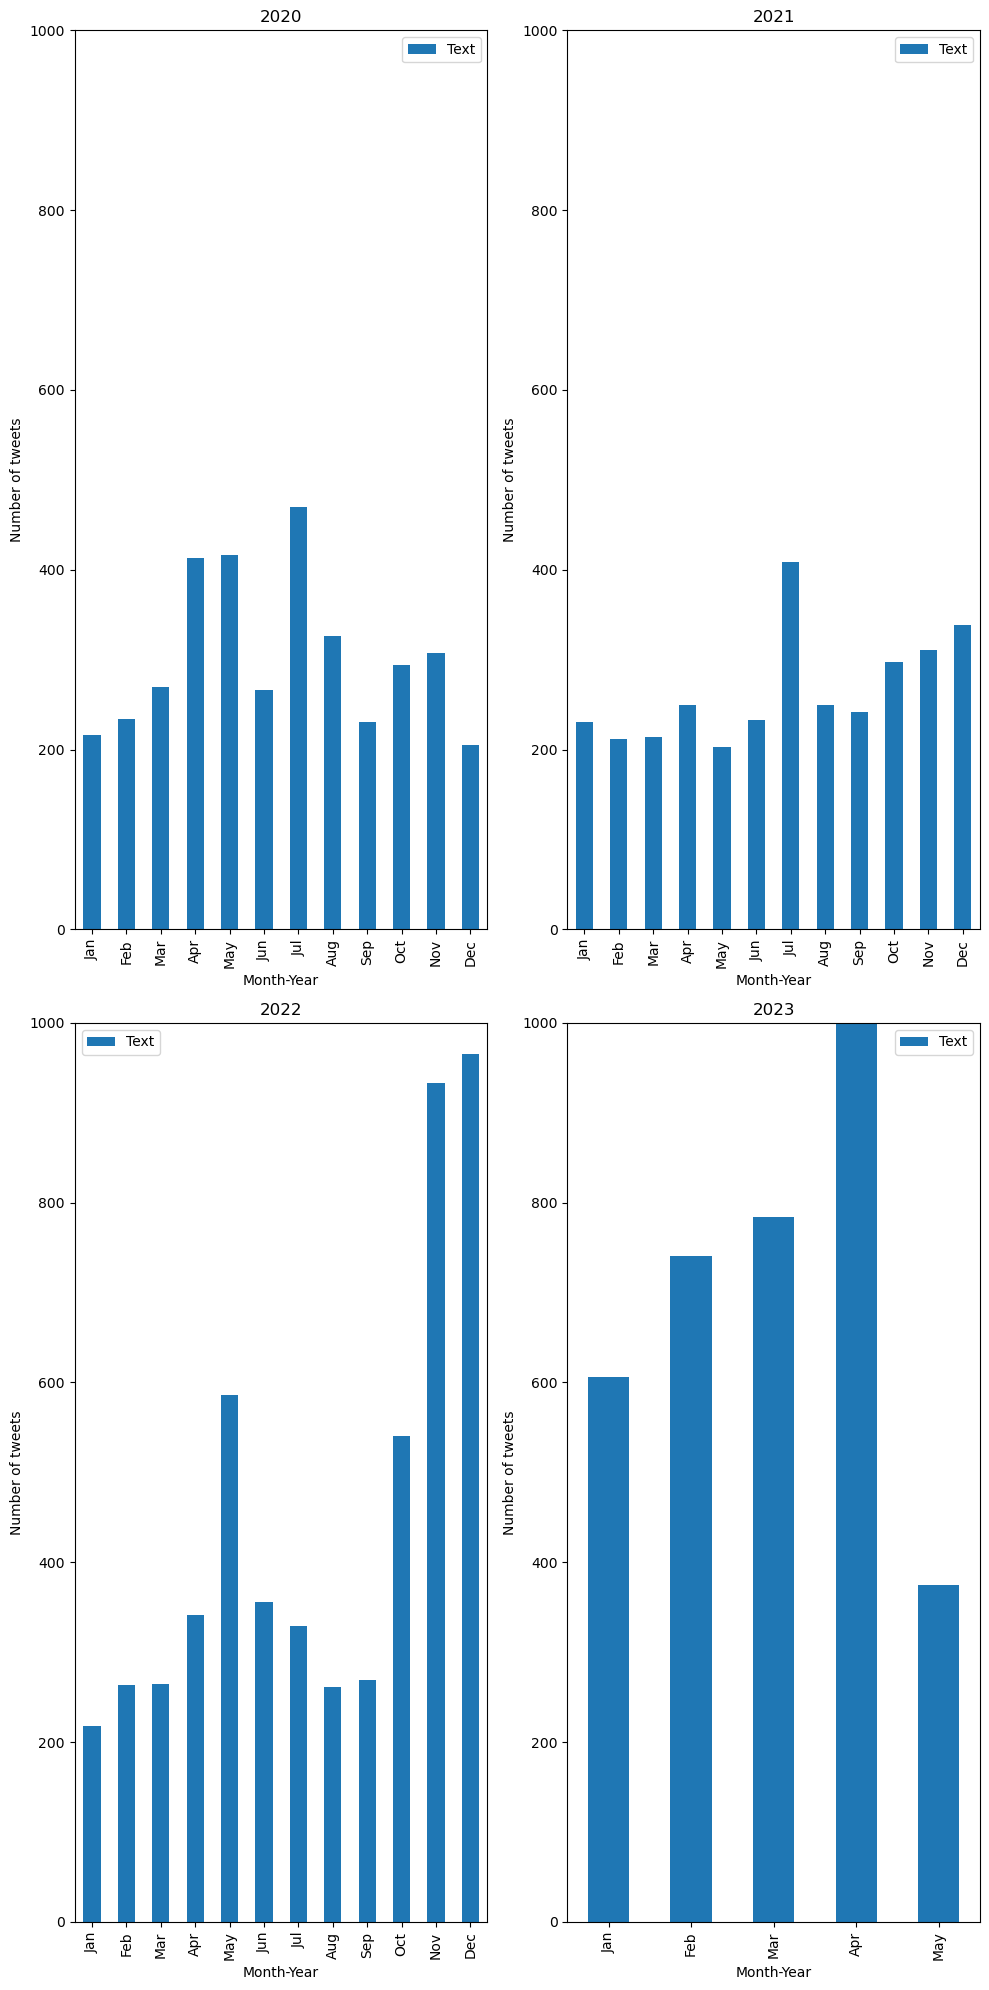

In [3]:
monthly_tweet_counts = tweets.groupby(pd.Grouper(freq='M')).count()

# Group the monthly tweet counts by the year of the 'Date' index
year_month_group = monthly_tweet_counts.groupby(monthly_tweet_counts.index.year) 
# # Create a grid of subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 20))

# Iterate over each year and plot the monthly tweet counts on a subplot histogram
for ax, year in zip(axes.flatten(), year_month_group):
    
    # Select just the monthly tweet counts for the year
    year[1].plot(kind='bar', ax=ax, title=year[0])
    # Set the x-axis label to 'Month-Year'
    ax.set_xlabel('Month-Year')
    # Set the y-axis label to 'Number of tweets'
    ax.set_ylabel('Number of tweets')

    #x -axis ticks not with dates but months 
    ax.set_xticklabels(year[1].index.strftime('%b'))
    # Use the same y-axis scale for all subplots
    ax.set_ylim([0, 1000])
    
# Adjust the spacing between the subplots
plt.tight_layout()    

# # Display the plot
plt.show()

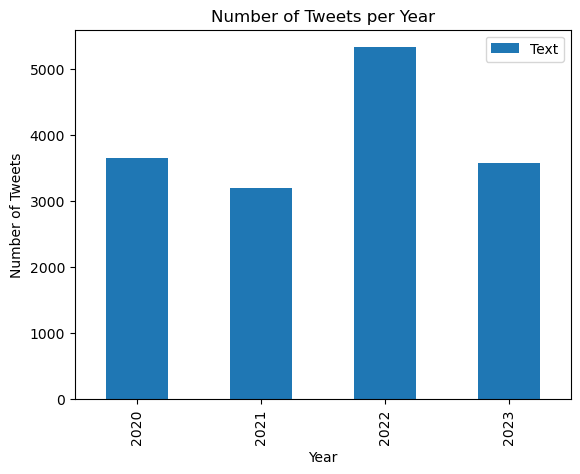

In [4]:
# Numbe of tweets per year 2020/2023
tweets_per_year = tweets.groupby(tweets.index.year).count()

tweets_per_year.plot(kind='bar', title='Number of Tweets per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.show()

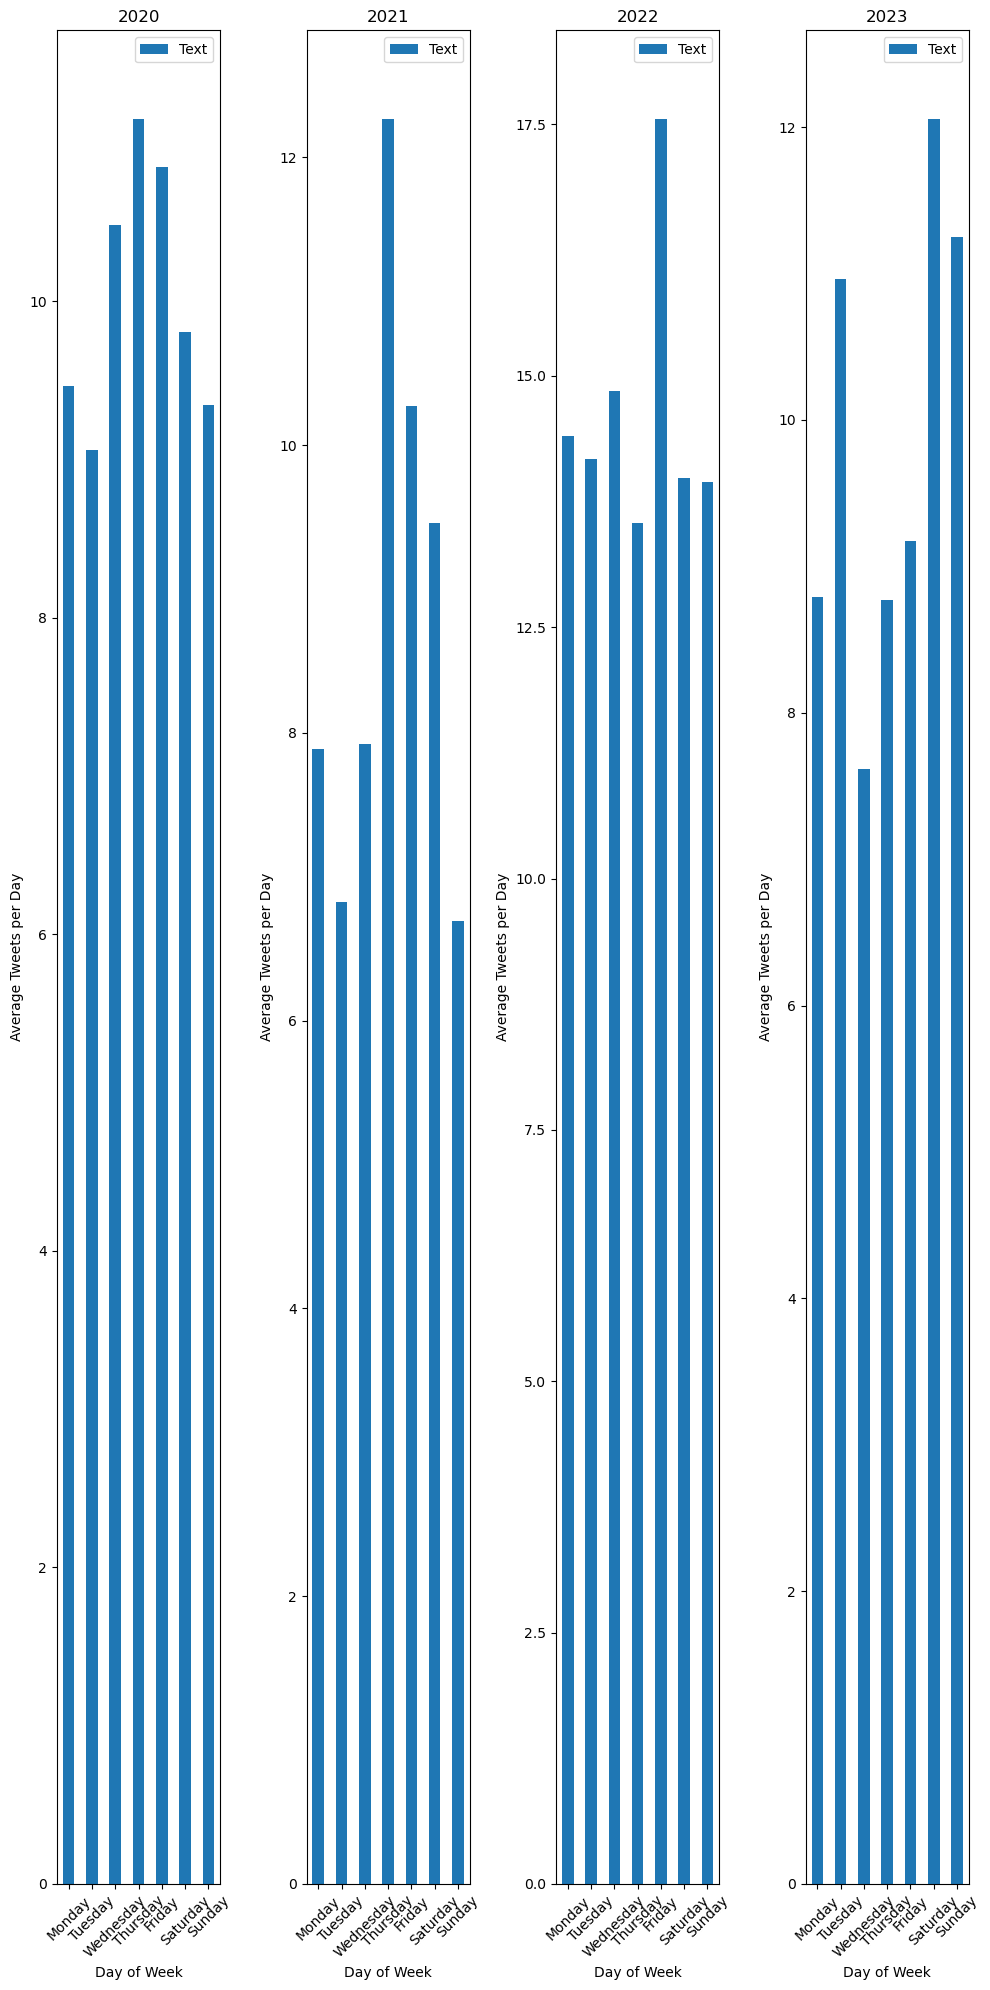

In [5]:
# Define the names of the days of the week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 20))

# Loop over the years 2020-2023
for i, year in enumerate(range(2020, 2024)):
    # Filter the tweets DataFrame to include only data from the current year
    tweets_year = tweets.loc[str(year)]
    tweets_year['DayOfWeek'] = tweets_year.index.dayofweek

    # Get the total number of tweets for each day of the week
    total_tweets_per_day = tweets_year.groupby('DayOfWeek').count()

    # Get the number of weeks in the current year
    num_weeks = len(pd.date_range(str(year) + '-01-01', str(year) + '-12-31', freq='W-MON'))

    # Divide the total number of tweets by the number of weeks to get the average number of tweets per day
    avg_tweets_per_day = total_tweets_per_day / num_weeks
    # Plot the average tweets per day for the current year using the week days list for the x-axis labels

    avg_tweets_per_day.plot(kind='bar', ax=axes[i], title=year)
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Average Tweets per Day')
    axes[i].set_xticklabels(day_names, rotation=45)


# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.show()  

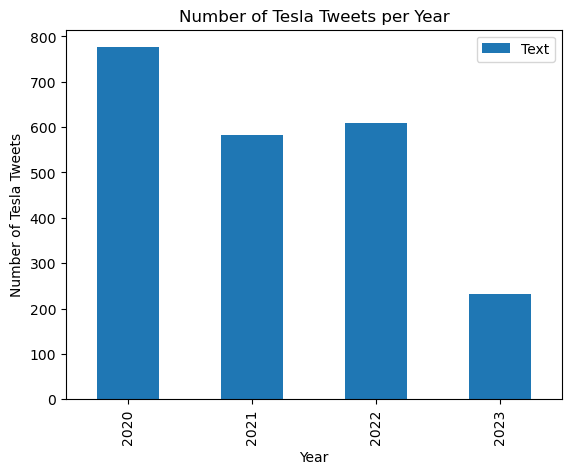

In [6]:
# Plot for each year how many time elon musk tweeted about tesla
tesla_tweets = tweets[tweets['Text'].str.contains('|'.join(['Tesla', 'TSLA']), case=False)] # check also TSLA
tesla_tweets_per_year = tesla_tweets.groupby(tesla_tweets.index.year).count()
tesla_tweets_per_year.plot(kind='bar', title='Number of Tesla Tweets per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tesla Tweets')
plt.show()


In [7]:
# Raw text for VADER (without usernames)
tweets['RawText'] = tweets['Text'].apply(lambda tweet: re.sub(r'@[A-Za-z0-9_]+', '', tweet))

In [8]:
# Cleaning the text column in each of the tweets

# Create a list of punctuation marks
punctuations = string.punctuation

# Create a list of stopwords
stop_words = stopwords.words('english')

# Create a function to clean the tweets
def clean_tweets(tweet):
    # Remove usernames
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
    # Remove emojis 
    tweet = emoji.demojize(tweet)
    # Tokenize the tweet by words
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    tweet_no_stopwords = [word.lower() for word in tweet_tokens if word.lower() not in stop_words]
    # Remove punctuation
    tweets_no_punc = [''.join([char for char in word if char not in punctuations]) for word in tweet_no_stopwords]
    # Remove empty strings
    tweets_no_punc = [word for word in tweets_no_punc if word != '']
    # Remove links
    tweets_no_punc = [word for word in tweets_no_punc if not 'http' in word]
    # Remove words with one character
    tweets_no_punc = [word for word in tweets_no_punc if len(word) > 1]

    return tweets_no_punc

# Clean the tweets
tweets['Text'] = tweets['Text'].apply(lambda x: str(clean_tweets(x)))

# Print the first 5 rows of the cleaned tweets
tweets['Text'].head()





Date
2020-01-01 05:32:00                                   ['carlos', 'gone']
2020-01-01 06:33:00    ['one', 'suspected', 'disguise', 'tcoyhl4mdrjtn']
2020-01-01 06:50:00    ['congratulations', 'tesla', 'amp', 'spacex', ...
2020-01-04 03:25:00    ['wow', 'built', 'first', 'server', 'room', 'p...
2020-01-04 03:33:00    ['people', 'talk', 'products', 'love', 'touch'...
Name: Text, dtype: object

In [9]:
#Using lemmatization to reduce the words to their root form

# Create a function to lemmatize the tweets
def lemmatize_tweets(tweet):

    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize the tweet
    tweet_lemmatized = [lemmatizer.lemmatize(word) for word in tweet]
    # Return the list of lemmatized words
    return tweet_lemmatized

# Lemmatize the tweets
tweets['Text'] = tweets['Text'].apply(lambda x: lemmatize_tweets(eval(x)))

# Print the first 5 rows of the cleaned tweets
tweets['Text'].head()


Date
2020-01-01 05:32:00                                       [carlos, gone]
2020-01-01 06:33:00            [one, suspected, disguise, tcoyhl4mdrjtn]
2020-01-01 06:50:00    [congratulation, tesla, amp, spacex, great, 20...
2020-01-04 03:25:00    [wow, built, first, server, room, part, fry, e...
2020-01-04 03:33:00    [people, talk, product, love, touch, heart, am...
Name: Text, dtype: object

In [10]:
# import counter from collections
from collections import Counter

# count the number of times each word appears in all tweets using Counter
all_words = [word for tokens in tweets['Text'] for word in tokens]
count_all_words = Counter(all_words)


#eliminate amp, rt and nt from the list of most common words
count_all_words = Counter({key: value for key, value in count_all_words.items() if key not in ['amp', 'rt', 'nt']})


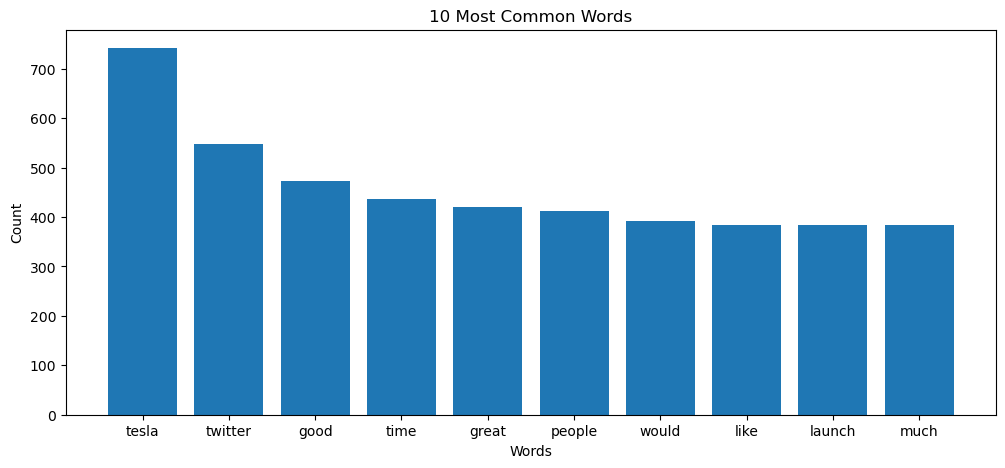

In [11]:
# Get the 10 most common words
common_words = count_all_words.most_common(10)
#Barplot of the 10 most common words with their counts
#Get more space between the bars
plt.figure(figsize=(12, 5))

plt.bar([word[0] for word in common_words], [word[1] for word in common_words])
plt.title('10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


In [12]:
#create a new column in dataframe call 'contains_tesla' and set it to 1 if the tweet contains the word 'Tesla' and 0 otherwise
tweets['contains_tesla'] = tweets['Text'].apply(lambda x: 1 if 'tesla' in x else 1 if 'tsla' in x else 0)
#Get the sum of the contains_tesla column
tweets['contains_tesla'].sum()

number_tesla= tweets['contains_tesla'].sum() / len(tweets)
print('The percentage of tweets that contain the words Tesla or TSLA is {:.2%}'.format(number_tesla))


#Doing the same for spaceX but not containing the world tesla
tweets['contains_spacex'] = tweets['Text'].apply(lambda x: 1 if 'spacex' in x and 'tesla' not in x else 0)
tweets['contains_spacex'].sum()

number_spacex= tweets['contains_spacex'].sum()  /len(tweets)
print('The percentage of tweets that contain the word SpaceX is {:.2%}'.format(number_spacex))


The percentage of tweets that contain the words Tesla or TSLA is 4.36%
The percentage of tweets that contain the word SpaceX is 1.26%


## Sentiment analysis using TextBlob

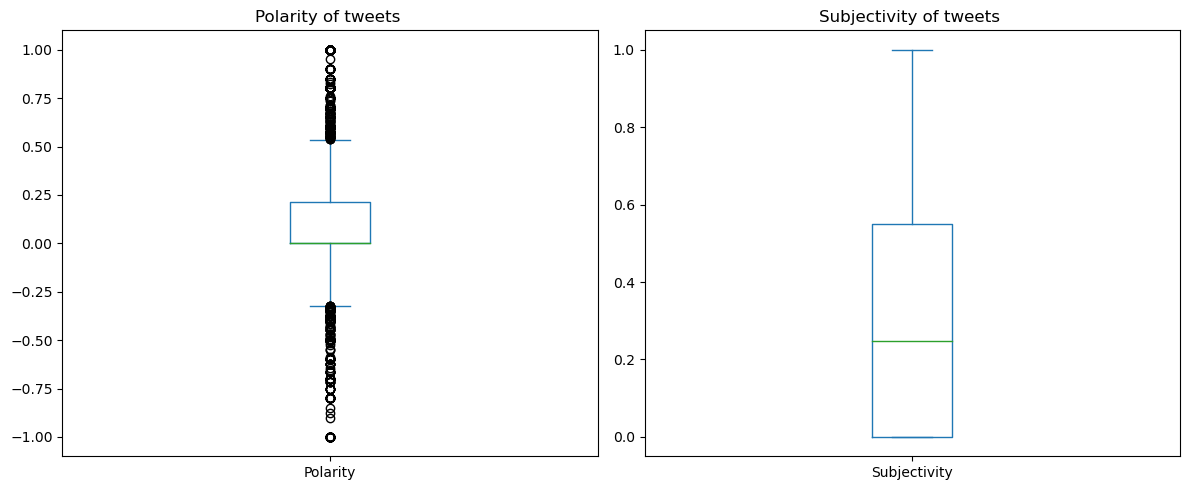

The mean polarity of the tweets is 0.11
The mean subjectivity of the tweets is 0.30


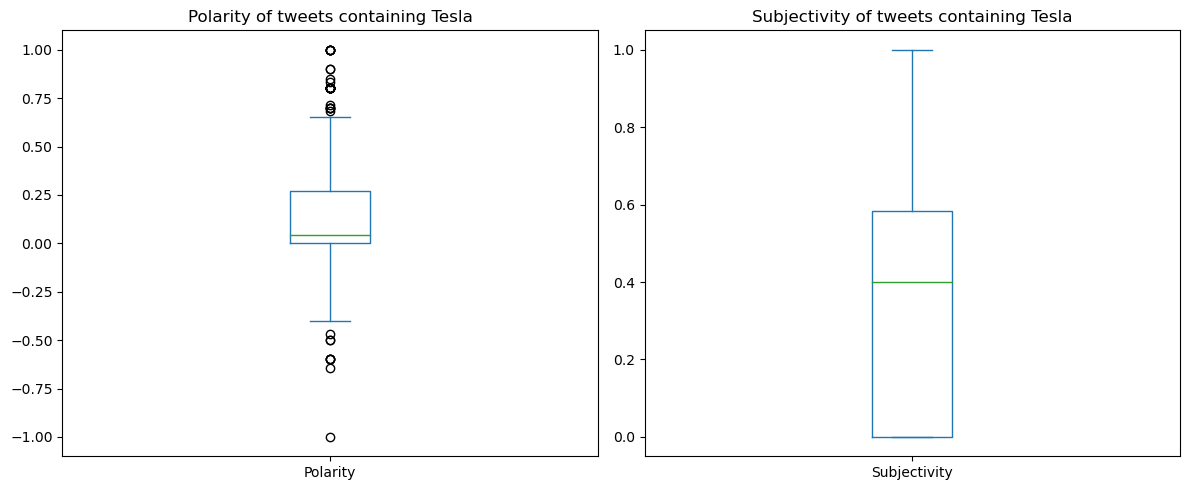

The mean polarity of the tweets containing Tesla is 0.14
The mean subjectivity of the tweets containing Tesla is 0.37


In [13]:
#Sentiment analysis of the tweets using the Text column in the tweets dataframe
#Polarity in the range [-1, 1] where -1 is the most negative and 1 is the most positive
#Subjectivity in the range [0, 1] where 0 is the most objective and 1 is the most subjective


# Create a function to get the polarity of the tweets
def get_polarity(tweet):
    # Create a TextBlob object
    analysis = TextBlob(tweet)
    # Return the polarity
    return analysis.sentiment.polarity

# Create a function to get the subjectivity of the tweets
def get_subjectivity(tweet):
    # Create a TextBlob object
    analysis = TextBlob(tweet)
    # Return the subjectivity
    return analysis.sentiment.subjectivity

# Create a column for the polarity of the tweets

tweets['Polarity'] = tweets['Text'].apply(lambda x: get_polarity(str(x)))

# Create a column for the subjectivity of the tweets
tweets['Subjectivity'] = tweets['Text'].apply(lambda x: get_subjectivity(str(x)))

# Plot the boxplot of the polarity and subjectivity of tweets in two subplots   
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
tweets['Polarity'].plot(kind='box', ax=ax1)
ax1.set_title('Polarity of tweets ')
ax2.set_title('Subjectivity of tweets ')

tweets['Subjectivity'].plot(kind='box', ax=ax2)
plt.tight_layout()
plt.show()


#Getting insights on the polarity and subjectivity of the tweets
#Print the mean polarity of the tweets
print('The mean polarity of the tweets is {:.2f}'.format(tweets['Polarity'].mean()))

#Print the mean subjectivity of the tweets
print('The mean subjectivity of the tweets is {:.2f}'.format(tweets['Subjectivity'].mean()))


#Plotting the polarity and subjectivity of tweets containing tesla

# Plot the boxplot of the polarity and subjectivity of tweets containing tesla in two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
tweets[tweets['contains_tesla'] == 1]['Polarity'].plot(kind='box', ax=ax1)
tweets[tweets['contains_tesla'] == 1]['Subjectivity'].plot(kind='box', ax=ax2)

ax1.set_title('Polarity of tweets containing Tesla')
ax2.set_title('Subjectivity of tweets containing Tesla')
plt.tight_layout()
plt.show()


#Show that the polarity and subjectivity of tweets containing tesla are higher than the polarity and subjectivity of all tweets
#Print the mean polarity of the tweets containing tesla
print('The mean polarity of the tweets containing Tesla is {:.2f}'.format(tweets[tweets['contains_tesla'] == 1]['Polarity'].mean()))

#Print the mean subjectivity of the tweets containing tesla
print('The mean subjectivity of the tweets containing Tesla is {:.2f}'.format(tweets[tweets['contains_tesla'] == 1]['Subjectivity'].mean()))



## Sentiment analysis using VADER

In [14]:
vader_analyzer = SentimentIntensityAnalyzer()

def sentiment_decider(compound):
    polarity = "neutral"

    if(compound >= 0.05):
        polarity = "positive"

    elif(compound <= -0.05):
        polarity = "negative"

    return polarity


def predict_polarity_vader(text):
    output_dict =  vader_analyzer.polarity_scores(text)
    return output_dict['compound']

def predict_sentiment_vader(text):
    output_dict =  vader_analyzer.polarity_scores(text)
    return sentiment_decider(output_dict['compound'])

tweets['polarity_vader'] = tweets['RawText'].apply(lambda x: predict_polarity_vader(x))
tweets['sentiment_vader'] = tweets['RawText'].apply(lambda x: predict_sentiment_vader(x))

dataset = tweets
dataset = dataset[['polarity_vader', 'RawText', 'sentiment_vader', 'contains_tesla']]

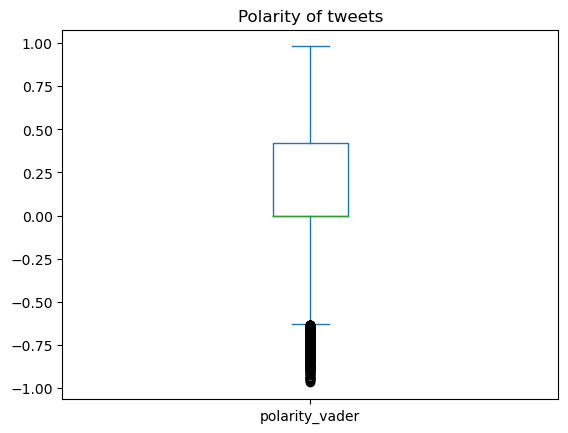

The mean polarity of the tweets is 0.15


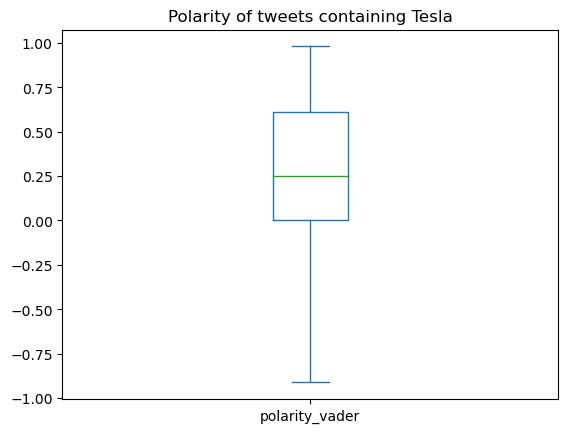

The mean polarity of the tweets containing Tesla is 0.25


In [15]:
tweets['polarity_vader'].plot(kind='box')
plt.title('Polarity of tweets')
plt.show()


#Getting insights on the polarity and subjectivity of the tweets
#Print the mean polarity of the tweets
print('The mean polarity of the tweets is {:.2f}'.format(tweets['polarity_vader'].mean()))


#Plotting the polarity and subjectivity of tweets containing tesla

# Plot the boxplot of the polarity and subjectivity of tweets containing tesla in two subplots

tweets[tweets['contains_tesla'] == 1]['polarity_vader'].plot(kind='box')

plt.title('Polarity of tweets containing Tesla')
plt.show()


#Show that the polarity and subjectivity of tweets containing tesla are higher than the polarity and subjectivity of all tweets
#Print the mean polarity of the tweets containing tesla
print('The mean polarity of the tweets containing Tesla is {:.2f}'.format(tweets[tweets['contains_tesla'] == 1]['polarity_vader'].mean()))


## Stock analysis (daily returns)

[*********************100%***********************]  1 of 1 completed


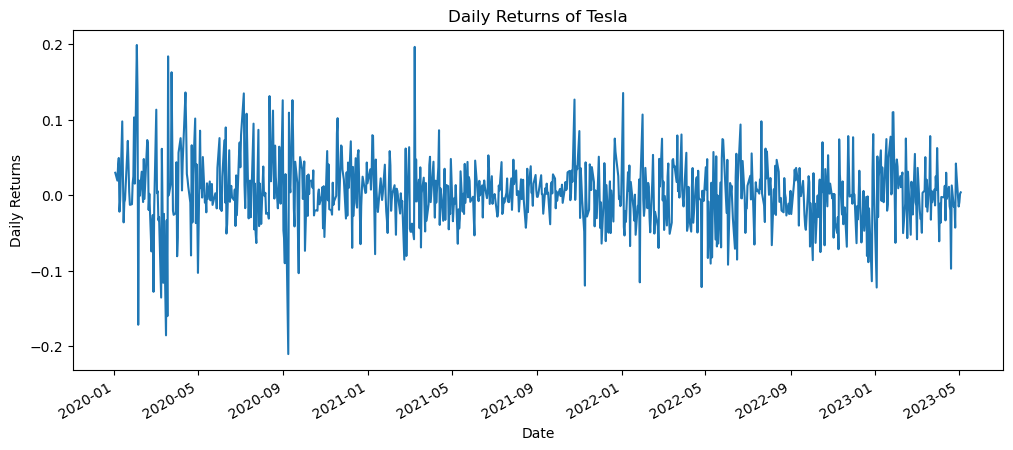

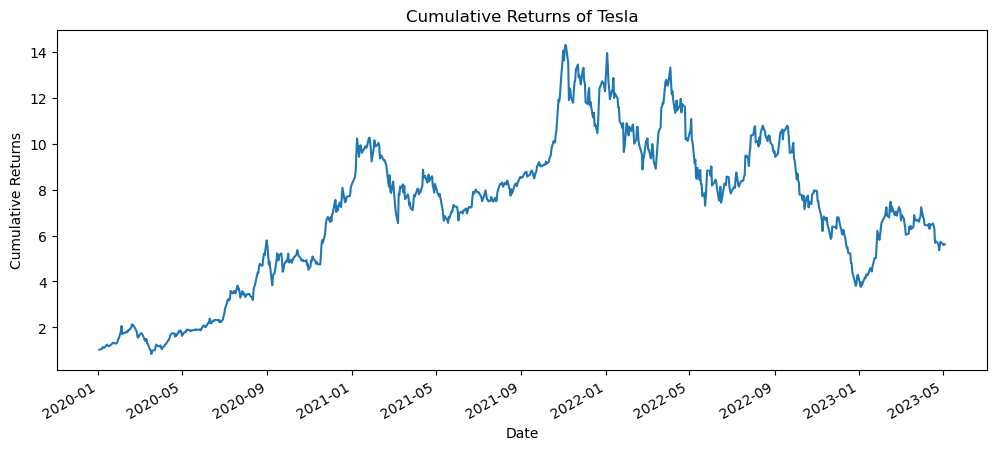

In [16]:
import yfinance as yf

# Set the start and end dates
start_date = "2020-01-01"
end_date = "2023-05-05"

# Get the stock data for Tesla from Yahoo Finance
ticker = "TSLA"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate the daily returns only using the adjusted close 
#use a 1-day lag.
daily_returns = stock_data['Adj Close'].pct_change(1).dropna()

# Plot the daily returns
daily_returns.plot(figsize=(12, 5))
plt.title('Daily Returns of Tesla')
plt.ylabel('Daily Returns')
plt.show()

#Plot the cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.plot(figsize=(12, 5))
plt.title('Cumulative Returns of Tesla')
plt.ylabel('Cumulative Returns')
plt.show()

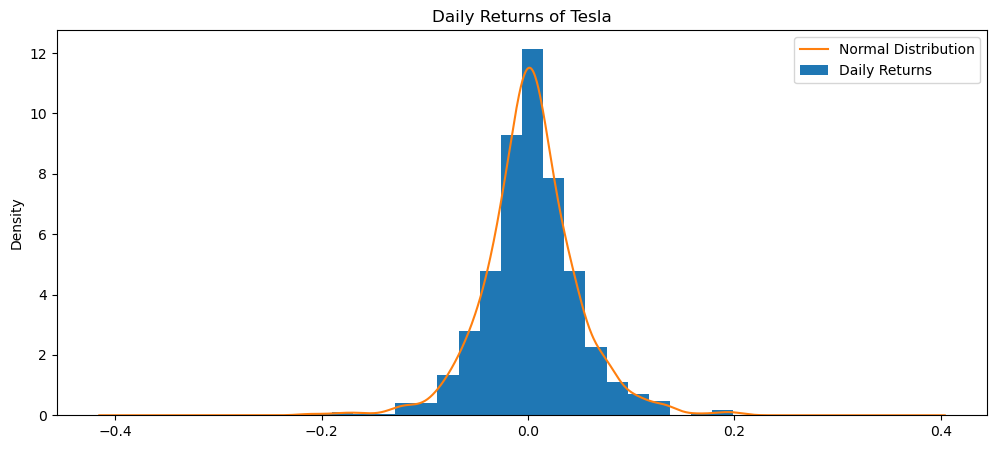

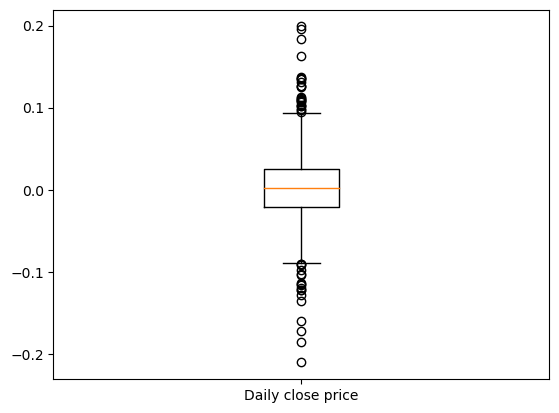

In [17]:
#Probability distribution of daily returns
#compare with the normal distribution
# Plot the histogram of the daily returns


# Plot the histogram of the daily returns with a normal distribution overlay
daily_returns.hist(bins=20, figsize=(12, 5), density=True)
daily_returns.plot(kind='density', figsize=(12, 5))
plt.title('Daily Returns of Tesla')
#put a legend
plt.legend(['Normal Distribution', 'Daily Returns'])
plt.show()








#Boxplot of daily returns
plt.boxplot(daily_returns,labels=["Daily close price"])
plt.show()


In [18]:
#Analysis 
#Boxplot full of outliers , The interquartile range is quite narrow -> fat tails

In [19]:
#Some statistics on the daily returns
#Print the mean of the daily returns
print('The mean of the daily returns is {:.5f}'.format(daily_returns.mean()))
#Print standard deviation of the daily returns
print('The standard deviation of the daily returns is {:.2f}'.format(daily_returns.std()))


#Skewness and kurtosis of the daily returns
#Print the skewness of the daily returns
#It’s positive, so we can assume that the distribution is not symmetrical 
print('The skewness of the daily returns is {:.2f}'.format(skew(daily_returns)))

#Statistcial test on skweness
#Print the p-value of the Jarque-Bera test
#The p-value is less than 0.05, so we can reject the null hypothesis that the distribution is normal
#we reject the null hypothesis and conclude that the data is unlikely to be normally distributed
skewtest(daily_returns)


#Kurtosis  
#Print the kurtosis of the daily returns
kurtosis(daily_returns)
#test
#Again, a very small p-value lets us reject the null hypothesis that the kurtosis is the same as a normal distribution
kurtosistest(daily_returns)


The mean of the daily returns is 0.00307
The standard deviation of the daily returns is 0.05
The skewness of the daily returns is 0.08


KurtosistestResult(statistic=7.486607759803677, pvalue=7.067651885268642e-14)

[*********************100%***********************]  1 of 1 completed


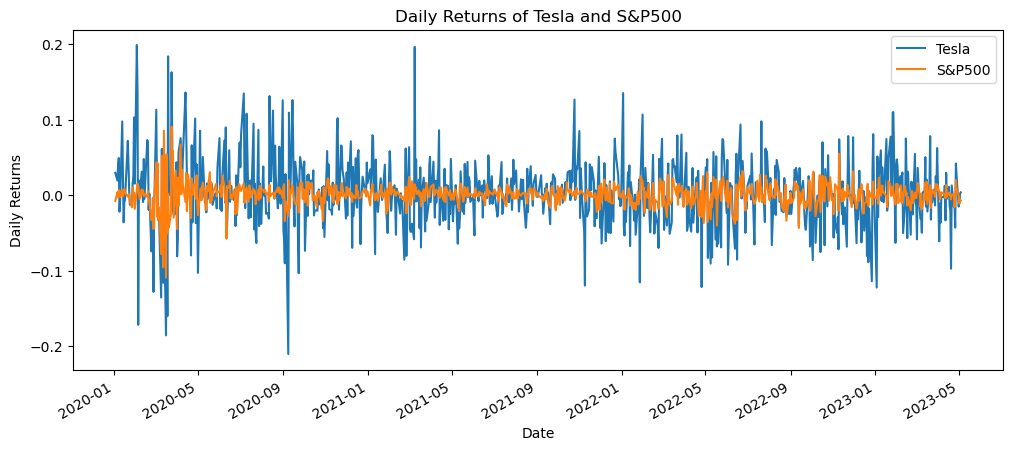

In [20]:
#Compare on a plot daily return of SP500 and Tesla
#Get daily returns of SP500
# Set the start and end dates
start_date = "2020-01-01"
end_date = "2023-05-05"

# Get the stock data for S&P500 from Yahoo Finance
ticker = "SPY"

stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate the daily returns only using the adjusted close 
#use a 1-day lag.
daily_returns_SP = stock_data['Adj Close'].pct_change(1).dropna()

#Plot the daily returns of Tesla and SP500
daily_returns.plot(figsize=(12, 5),label="Tesla")
daily_returns_SP.plot(figsize=(12, 5),label="S&P500")
plt.title('Daily Returns of Tesla and S&P500')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()


## Tesla stocks and tweets  






In [21]:
tweets['only_date'] = tweets.index
# dataset timestamps are in GMT, so NYSE opens at 09:30 locally, i.e. 13:30 GMT
tweets['only_date'] = tweets['only_date'].apply(lambda x: datetime.date(x.year,x.month,x.day) + datetime.timedelta(days=3) if datetime.date(x.year,x.month,x.day).weekday() == 4 and (x.hour > 13 or x.hour == 13 and x.minute > 30) else datetime.date(x.year,x.month,x.day) + datetime.timedelta(days=2) if datetime.date(x.year,x.month,x.day).weekday() == 5 else datetime.date(x.year,x.month,x.day) + datetime.timedelta(days=1) if datetime.date(x.year,x.month,x.day).weekday() == 6 or x.hour > 13 or x.hour == 13 and x.minute > 30 else datetime.date(x.year, x.month, x.day))
tweets['Tweet'] = tweets['Text'].apply(lambda x: [x])
tweets['Polarity_list'] = tweets['Polarity'].apply(lambda x: [x])
tweets['polarity_vader_list'] = tweets['polarity_vader'].apply(lambda x: [x])
tweets['sentiment_vader_list'] = tweets['sentiment_vader'].apply(lambda x: [x])

add_weight_tesla = 9
tweets['polarity_textblob_weighted'] = tweets['Polarity'] * (1 + tweets['contains_tesla'] * add_weight_tesla)
tweets['polarity_textblob_weighted_list'] = tweets['polarity_textblob_weighted'].apply(lambda x: [x])
tweets['polarity_vader_weighted'] = tweets['polarity_vader'] * (1 + tweets['contains_tesla'] * add_weight_tesla)
tweets['polarity_vader_weighted_list'] = tweets['polarity_vader_weighted'].apply(lambda x: [x])
tweets['weight_polarity'] = 1 + tweets['contains_tesla'] * add_weight_tesla
tweets['weight_polarity_list'] = tweets['weight_polarity'].apply(lambda x: [x])

df_tweets_returns = tweets[['only_date', 'Tweet', 'polarity_textblob_weighted_list', 'polarity_vader_weighted_list', 'sentiment_vader_list', 'weight_polarity_list']].groupby('only_date').sum()
df_tweets_returns.index.names = ['Date']


df_temp_sum_pol_textblob = df_tweets_returns['polarity_textblob_weighted_list'].apply(lambda x: sum(x))
df_temp_weight_pol = df_tweets_returns['weight_polarity_list'].apply(lambda x: sum(x))
df_tweets_returns['mean_polarity_textblob'] = df_temp_sum_pol_textblob / df_temp_weight_pol
df_temp_sum_pol_vader = df_tweets_returns['polarity_vader_weighted_list'].apply(lambda x: sum(x))
df_tweets_returns['mean_polarity_vader'] = df_temp_sum_pol_vader / df_temp_weight_pol


In [22]:
# merged dataset
df_tesla_vol = pd.read_csv('Tesla_Daily_Std.csv', index_col=0)
df_tesla_vol.index = pd.to_datetime(df_tesla_vol.index).to_series().apply(lambda x: datetime.date(x.year,x.month,x.day))
df_tesla_vol.index.names = ['Date']

df_ts = df_tesla_vol.merge(df_tweets_returns, on='Date')
df_ts.to_csv("DF_TS.csv")

In [23]:
df_tesla_vol.describe()

,daily_vol
count,837.000000
mean,0.004435
std,0.003500
min,0.000859
25%,0.002764
50%,0.003754
75%,0.005105
max,0.075353
